In [1]:
%run ../talktools.py

## Using MCMC to fit real data

### AY 128/256 (UC Berkeley, 2021)

* Let's look at a famous dataset
<img src="hubble_diagram.jpg" width="90%">
* Hubble (1929) finds that more distant galaxies have larger positive velocities than closer galaxies
* Ends up being a big deal
* What were some of our crisiticms of this plot, and by extension the result, from our first meeing?

## Our challenge
* Hubble found $H_0 \sim 500$ km/s/Mpc, more or less fitting data with no error bars by eye.
* Let's see how well this result stands up to more detailed analysis.

## Step 1: Data Wrangling
* We need to get Hubble's data
* Fortunately, it's in Table 1 of Hubble (1929)
<img src="hubble_table.jpeg" width="80%">

 - $m_s$ = photographic magnitude of brightest stars involved.

 - $r$ = distance in units of $10^6$ parsecs. The first two are Shapley’s values.

 - $v$ = measured velocities in $km./sec$.    N. G. C. 6822, 221, 224 and 5457 are recent determinations by Humason.

 - $m_t$ = Holetschek’s visual magnitude as corrected by Hopmann. The first three objects were not measured by Holetschek, and the values of mt represent estimates by the author based upon such data as are available.

 - $M_t$ = total visual absolute magnitude computed from m_t and $r$.

* Since it's a short table, I turned this into a csv file by hand.  It contains galaxy name, distance, velocity, and absolute magnitude.

## Step 1: Data Visualization
* Let's use Pandas to read in the data and try to re-create Hubble's plot

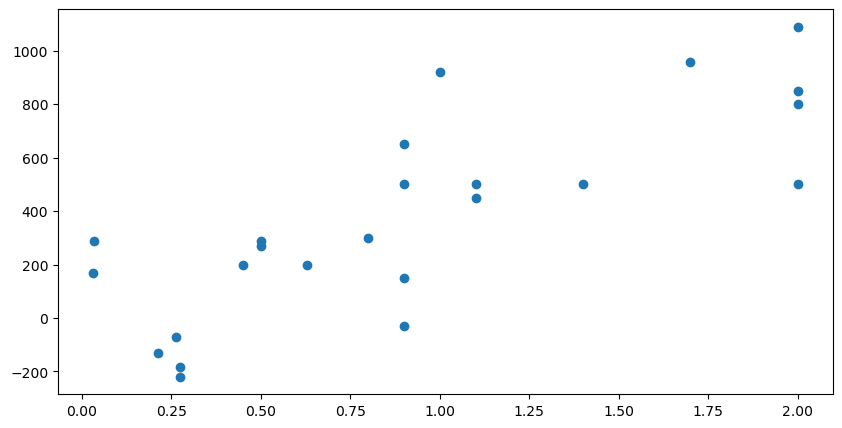

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


# read in the csv file; column names are in the file already
df = pd.read_csv('hubble1929.tab1')

import pylab as plt
# plot distance and velocity
plt.scatter(df['distance'], df['velocity'])

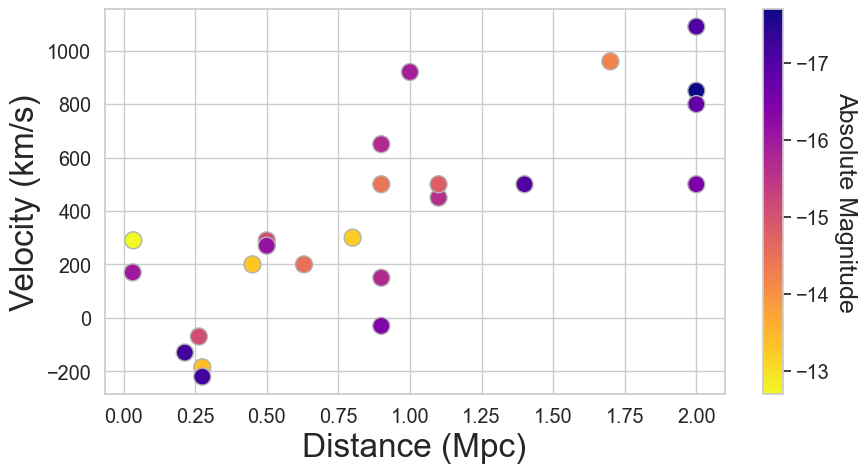

In [3]:
# Let's make this plot look a bit nicer using Seaborn
import numpy as np


import seaborn as sns
sns.set(style="whitegrid", color_codes=True, font_scale=1.3)

cmap = plt.get_cmap('plasma')

plt.scatter(df['distance'], df['velocity'], c=df['absMag'], s=150, edgecolor='0.7', cmap=cmap)
plt.xlabel('Distance (Mpc)', size=24)
plt.ylabel('Velocity (km/s)', size=24)

cb = plt.colorbar()
cb.set_label("Absolute Magnitude", rotation=270, labelpad=20, fontsize=18)

# make colorbar brighest to faintest
cb.ax.invert_yaxis()


## Step 3a: Write down a model for the data
* $y_n = m*x_n + b$
 - Linear model to descibe velocity as a function of distance
 - 2 parameters to fit for: $m$ (slope) and $b$ (offset)
 - $y_n$: velocity of the nth galaxy; $x_n$: distance to the nth galaxy
 - We have no error bars (i.e., no $\sigma_n$) -- is this a problem? Why or why not?

## Step 3b: Error bars
* Let's fit for the scatter in the data (or the size of the typical uncertainty)
* Assume errors are normally distributed
* error term: $logsig = log(\sigma)$
* why use $log(\sigma)$ instead of $\sigma$ as a parameter?

## Aside Review Bayes's theorem
* Bayes's theorem: $P(\theta \mid \{y_n\}) \propto P(\{y_n\} \mid \theta) \, P(\theta)$
 - $\theta = \{m,b,\log(\sigma)\}$
* Assume we have $N$ independent data points (i.e., galaxies in this case).  The posterior for the entire dataset is the product of the posteriors for each data point.

 - $P(\theta \mid \{y_n\}) = \prod_n^N P(\theta \mid y_n) \propto\ \prod_n^N P( y_n \mid \theta)\, P(\theta)$ 
 

* Or in log-space:
 - $\log P(\theta \mid \{y_n\}) \propto \sum_n^N \log P(y_n \mid \theta) + \log P(\theta)$
 - why work in log-space?

## Step 4: Write down priors and log-likelihood

* Uniformative prior on $m$:

 $$
P(m)=
\begin{cases}
1 \, \rm{if} \, 100 < m < 1000\\
0 \, {\rm otherwise}\\
\end{cases}
$$

* Uniformative prior on $b$:

 $$
P(b)=
\begin{cases}
1 \, \rm{if} -500 < b < 500\\
0 \, {\rm otherwise}\\
\end{cases}
$$

* Uniformative prior on $\log(\sigma)$:

 $$
P(b)=
\begin{cases}
1 \, \rm{if} -10 < \log(\sigma) < 10\\
0 \, {\rm otherwise}\\
\end{cases}
$$
 

* Likelihood function for a normal distribution:

$ P(\{y_n\} \mid \{m, b, \log(\sigma)\}) = \frac{1}{\sqrt{2\pi\sigma}} e^{-\frac{(y_n - mx_n - b)^2}{2 \sigma^2}}$

 - where $x_n$ is shorthand for the 'distance' variable


* log-Likelihood function for a normal distribution:

 $ \log P(\{y_n\} \mid \{m, b, \log(\sigma)\} = -\frac{1}{2} \sum^{N}_{n=1} \Big(\frac{(y_n - mx_n - b)^2}{\sigma^2} + \log(2 \pi \sigma^2) \Big)$
 
   - how might this change if we had values for $\sigma_n$ already?

Another way of writing this model:
* $m \sim {\rm Uniform}(100, 1000)$
* $b \sim {\rm Uniform}(-500, 500)$
* $\log(\sigma) \sim {\rm Uniform}(-10,10)$
* $y_n \sim {\rm Normal}(m x_n +b, \sigma)$

## Steps 5 & 6: Implement and run the model in python using PyMC3, make some diagnostic plots
<a href="https://docs.pymc.io/api/distributions/continuous.html">This</a> is a reference to the types of distriutions availabe in PyMC3, which may be handy to you.





In [11]:
import pymc as pm

# set up the model
with pm.Model() as model:
    
    # define priors
    m = pm.Uniform("m", lower=100, upper=1000)
    b = pm.Uniform("b", lower=-500, upper=500)
    logsig = pm.Uniform("logsig", lower=-10, upper=10)
    
    # define the log-likelihood function
    # note that numpy doesn't play nicely with PyMC, so you should use their built in math functions
    pm.Normal("obs", mu = m*df['distance'].values+b, 
              sigma=pm.math.exp(logsig), observed=df['velocity'].values)

    # now set up the model to run
    # default of PyMC is to use the no-turn sampler (NUTS)
    
    # pm.sample will run the sampler and store output in 'trace' 
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=2)
    
    # traceplot is a routine for plotting the 'traces' from the samples
    _ = pm.traceplot(trace, var_names=["m", "b", "logsig"])
    
    # pm.summary provides some useful summary and convergance statistics
    pm.summary(trace, var_names=["m", "b", "logsig"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/jlu/code/mambaforge/envs/astro/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [m, b, logsig]


/Users/jlu/code/mambaforge/envs/astro/lib/python3.10/site-packages/pymc/step_methods/hmc/quadpotential.py:258: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/jlu/code/mambaforge/envs/astro/lib/python3.10/site-packages/pymc/step_methods/hmc/quadpotential.py:237: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


RuntimeError: Chain 1 failed.

In [ ]:
pm.summary(trace, var_names=["m", "b", "logsig"])

In [ ]:

# corner is a nice routine for visualizing the marginalized posterior distributions
# 1d plots (1d histograms) are called marginalized distributions
# 2d plots (2d histograms) are called joint (marginazlied) distributions

import corner

# translate trace into pandas dataframe for plotting (you can also plot numpy arrays with corner)
samples = pm.trace_to_dataframe(trace, varnames=["m", "b", "logsig"])

# make the corner plot and plot results from Hubble's paper as 'truth'
# overplot percentiles: 16, 50, 84 on 1d historgrams
_ = corner.corner(samples, truths=[500, 0, None], quantiles=[.16, .50, .84])

# how big is the scatter/typical error in the data?
# let's use the median of logsig for this
print(f"The typical error in velocity is ~{np.int(np.median(np.exp(trace['logsig'])))} km/s")

## Step 7: Posterior Predictive check
* the technical term that means to plot your model on top of the data and do a sanity check

In [ ]:
# Let's make this plot look a bit nicer using Seaborn

#import seaborn as sns
sns.set(style="whitegrid", color_codes=True, font_scale=1.3)
plt.scatter(df['distance'], df['velocity'], c=df['absMag'], s=150, edgecolor='0.7', cmap=cmap)
plt.xlabel('Distance (Mpc)', size=24)
plt.ylabel('Velocity (km/s)', size=24)
cb = plt.colorbar()
cb.set_label("Absolute Magnitude", rotation=270, labelpad=20, fontsize=18)

# make an array of 'distances'
dist = np.arange(0,2.1, 0.1)


# set random seed
np.random.seed(42)

# this code loops over the trace array and pulls 500 random sets of m,b, and logsig
# it then generates 500 posterior models (i.e., lines in velocity and distance space) and overplots them on the data

for i in np.random.randint(len(trace) * trace.nchains, size=500):
    plt.plot(dist, samples['m'][i]*dist + samples['b'][i], color="k", lw=0.1, alpha=0.3, zorder=0)

# overplot Hubble's values    
plt.plot(dist, 500*dist, color='r')


# tried to invert the y-axis, but ticklabels all disappear
#cb.ax.invert_yaxis()
#cb.set_ticks(np.arange(-13, -19, 2))
#cb.set_ticklabels(('-13', '-15', '-17', '-19'))

# should also add a legend of what the lines mean

## Step 8: Report some results
* what numbers might we report in the abstract of a paper?
* it's hard to succinctly describe a distribution/posterior PDF, so we often give a point estimate (i.e., a number with error bars)
* some options: MAP (maximum a posteriori), highest probablity density, mean, percentiles...

In [ ]:
# example with percentiles

from IPython.display import display, Math


units =[r'{\, \rm km/s/Mpc}', r'{\, \rm km/s}', r'{\, \rm km/s}']
labels = ['m', 'b', r'\sigma']

# we'll want logsig in linear units for the final comparison

for i, j in enumerate(samples.keys()):
    if j == 'logsig':
        summary = np.percentile(np.exp(samples[j]), [16, 50, 84])
    else:
        summary = np.percentile(samples[j], [16, 50, 84])
    diff = np.diff(summary)
    mathtext = "\mathrm{{{3}}} = {0:.1f}_{{-{1:.1f}}}^{{{2:.1f}}}"
    mathtext = mathtext.format(summary[1], diff[0], diff[1], labels[i])
    display(Math(mathtext + "  "+ units[i]))
    
 # probably too many significant digits   